# Forecasting beer sales 

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/


- https://catboost.ai/docs/concepts/python-reference_catboostregressor.html

## Install

In [461]:
# !pip install numpy
# !pip install pandas

# !pip install sklearn
# !pip install joblib
# !pip install optuna

# !pip install lightgbm
# !pip install xgboost
# !pip install catboost

# !pip install matplotlib
# !pip install seaborn
# !pip install rfpimp
# !pip install skater
# !pip install eli5

## Init

In [462]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn.experimental import enable_hist_gradient_boosting, enable_iterative_imputer
from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer, RobustScaler
from sklearn.inspection import permutation_importance
import joblib

import lightgbm  
import xgboost 
import catboost
# from keras.wrappers.scikit_learn import KerasRegressor
# from keras.models import Sequential
# from keras.layers import Dense
import optuna

# visualization lib
import matplotlib.pyplot as plt
import seaborn as sns
from rfpimp import permutation_importances, plot_importances, plot_corr_heatmap
# import shap
import eli5
from eli5.sklearn import PermutationImportance

In [463]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [464]:
def get_percentage_diff(previous, current):
    return 1 - (abs(previous - current)/max(previous, current))

def absolute_score(y_true, y_pred):
    return 1 - (np.sum(np.absolute(y_pred - y_true)) / np.sum(y_true))

def show_pred(y_test, y_pred, xlabel, ylabel):
    plt.figure(figsize=(8,6))
    plt.scatter(y_pred, y_test)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()


def show_feature_importances(model, X, y):
    model_name = type(model).__name__
    importances = None

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_       
    else:
        # r = permutation_importance(model, X, y, n_repeats=5, random_state=42, n_jobs=MAX_N_JOBS)
        # importances = r.importances_std
        # def r2(model, X_test, y_test):
        #     return mean_squared_error(y_test, model.predict(X_test))

        # imp = permutation_importances(model, X_test, y_test, metric=r2)
        # importances = imp.Importance.values
        perm = PermutationImportance(model, cv = None, refit = False).fit(X_train, y_train)
        importances = perm.feature_importances_

    sorted_idx = importances.argsort()

    plt.figure(figsize=(8,6)) 
    plt.barh(X.columns[sorted_idx], importances[sorted_idx])
    plt.xlabel(f"{model_name} - Feature Importance")
    plt.show()

def reduce_mem_usage(df, ignoreCols=[], verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:    
        if col in ignoreCols:
            continue

        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [465]:
DATASET_NAME = 'off-trade'

DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'

RESULT_CSV_PATH = f'./results/{DATASET_NAME}_result.csv'
RESULT_EXCEL_PATH = f'./results/{DATASET_NAME}_result.xlsx'

MAX_N_JOBS = 8

## Load Data

In [466]:
workdays = pd.read_csv(f'./data/workdays.csv', header=0, decimal=",")

workdays = workdays.rename(columns={"Workdays": "NumberWorkdays"})
workdays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         626 non-null    object
 1   Year            626 non-null    int64 
 2   Week            626 non-null    int64 
 3   NumberWorkdays  626 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.7+ KB


In [467]:
data_dtype = {'SkuShort':'str', 'Brand':'str', 'Country':'str', 'IsLockdown':'bool'} #'ProductGroup':'str', 'PrimaryPack':'str',

data = pd.read_csv(DATA_PATH, header=0, decimal=",", dtype=data_dtype)

# data_off_trade = pd.read_csv(f'./data/off-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data_on_trade = pd.read_csv(f'./data/on-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
# data = pd.concat([data_off_trade, data_on_trade], ignore_index=True)

data = data.sort_values(by=['Year', 'Week', 'SkuShort', 'Country']).reset_index().drop(columns=['index'])

if ('off-trade' in DATASET_NAME):
    lastYear = data.Year.max()
    data = data[(data.Year >= lastYear-3)]

data.head()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
16273,01015,PILSNER URQUELL,CZ,2018,1,4,5.1125,1.0625,0.925,False,1510.000000,9971.780620,1606.096830,2954.9000,5282.3000,14068.4000,1001.3000,1805.0000,3450.3998
16274,01015,PILSNER URQUELL,SK,2018,1,4,5.1125,1.0625,0.925,False,537.003748,3196.006833,611.244083,814.6000,1250.4000,2775.1000,195.7000,506.9000,555.1006
16275,01016,PILSNER URQUELL,CZ,2018,1,4,5.1125,1.0625,0.925,False,197.619048,NaN,147.586571,451.2816,371.9232,558.9936,130.1256,159.1128,410.0324
16276,01016,PILSNER URQUELL,SK,2018,1,4,5.1125,1.0625,0.925,False,15.232821,33.279701,32.377610,35.4024,35.3232,123.2352,20.4336,26.9280,21.9305
16277,01022,PILSNER URQUELL,CZ,2018,1,4,5.1125,1.0625,0.925,False,NaN,283.333333,84.234569,64.6800,229.0200,313.9950,99.3300,72.4900,99.5995


In [468]:
data = reduce_mem_usage(data, ignoreCols=['SalesHl'])

Mem. usage decreased to  1.97 Mb (56.2% reduction)


In [469]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30887 entries, 16273 to 47159
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SkuShort          30887 non-null  object 
 1   Brand             30887 non-null  object 
 2   Country           30887 non-null  object 
 3   Year              30887 non-null  int16  
 4   Week              30887 non-null  int8   
 5   NumberWorkdays    30887 non-null  int8   
 6   AvgTemp           30887 non-null  float16
 7   AvgRain           30887 non-null  float16
 8   AvgSun            30887 non-null  float16
 9   IsLockdown        30887 non-null  bool   
 10  PdtHl             24462 non-null  float16
 11  PrevWeekPdtHl1    24142 non-null  float16
 12  BgtHl             25763 non-null  float16
 13  SalesHl           30887 non-null  float64
 14  PrevWeekSalesHl1  29818 non-null  float16
 15  PrevWeekSalesHl2  29578 non-null  float16
 16  PrevYearSalesHl1  25896 non-null  fl

In [470]:
data.describe()

,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,30887.000000,30887.000000,30887.000000,3.088700e+04,30887.000000,3.088700e+04,2.446200e+04,2.414200e+04,25763.0000,30887.000000,29818.00000,2.957800e+04,25896.000,22966.00000,2.888600e+04
mean,2019.227992,25.320038,4.776735,inf,1.629883,inf,inf,inf,inf,627.726387,inf,inf,inf,inf,inf
std,0.976319,15.192694,0.505117,7.687500e+00,1.675781,3.095703e+00,inf,inf,inf,1510.144307,inf,inf,inf,inf,inf
min,2018.000000,1.000000,2.000000,-8.281250e+00,0.000000,1.428223e-01,5.279541e-02,5.279541e-02,-28.5625,0.000000,0.00000,0.000000e+00,0.000,0.00000,6.210327e-02
25%,2018.000000,12.000000,5.000000,3.277344e+00,0.399902,2.214844e+00,2.868750e+01,2.885938e+01,47.1875,22.080000,24.84375,2.529688e+01,38.625,51.84375,3.300000e+01
50%,2019.000000,24.000000,5.000000,9.960938e+00,1.062500,5.007812e+00,1.250625e+02,1.250000e+02,186.7500,119.040000,124.56250,1.251250e+02,165.375,185.75000,1.467500e+02
75%,2020.000000,39.000000,5.000000,1.679688e+01,2.365234,7.265625e+00,4.842500e+02,4.797500e+02,677.0000,536.640000,556.00000,5.555000e+02,642.000,679.00000,6.130000e+02
max,2021.000000,53.000000,5.000000,2.581250e+01,7.957031,1.386719e+01,2.523200e+04,2.523200e+04,15544.0000,24281.500000,24288.00000,2.428800e+04,24288.000,23152.00000,2.486400e+04


## Missing Values

In [471]:
data.isna().sum()

SkuShort            0   
Brand               0   
Country             0   
Year                0   
Week                0   
NumberWorkdays      0   
AvgTemp             0   
AvgRain             0   
AvgSun              0   
IsLockdown          0   
PdtHl               6425
PrevWeekPdtHl1      6745
BgtHl               5124
SalesHl             0   
PrevWeekSalesHl1    1069
PrevWeekSalesHl2    1309
PrevYearSalesHl1    4991
PrevYearSalesHl2    7921
OldPredSalesHl      2001
dtype: int64

## Data Visualizations

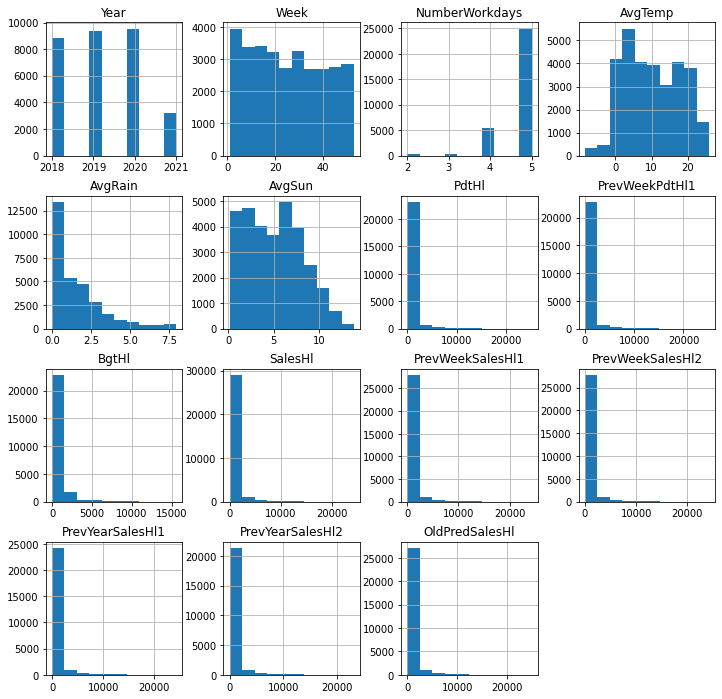

In [472]:
data.hist(figsize=[12,12])
plt.show()

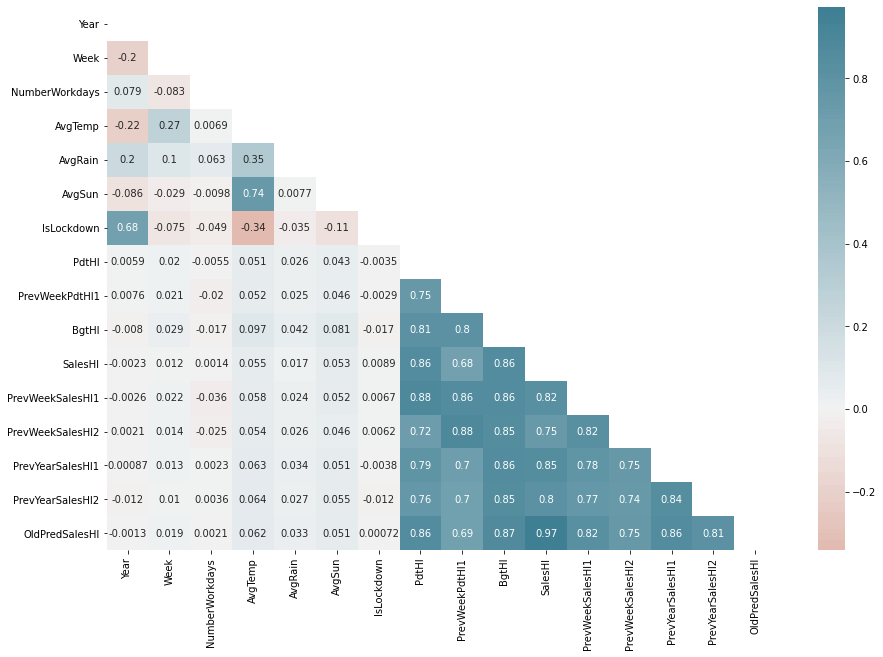

In [473]:
plt.subplots(figsize = (15,10))
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0)
plt.show()

In [474]:
numData = data.select_dtypes(exclude='object')
numDatacorr = numData.corr()
salesHlFrame = numDatacorr['SalesHl'].sort_values(ascending=False).head(10).to_frame()

salesHlFrame.style.background_gradient(cmap=sns.light_palette("cyan", as_cmap=True))

,SalesHl
SalesHl,1.000000
OldPredSalesHl,0.973277
BgtHl,0.863478
PdtHl,0.858267
PrevYearSalesHl1,0.851633
PrevWeekSalesHl1,0.816755
PrevYearSalesHl2,0.803864
PrevWeekSalesHl2,0.746760
PrevWeekPdtHl1,0.682936
AvgTemp,0.054709


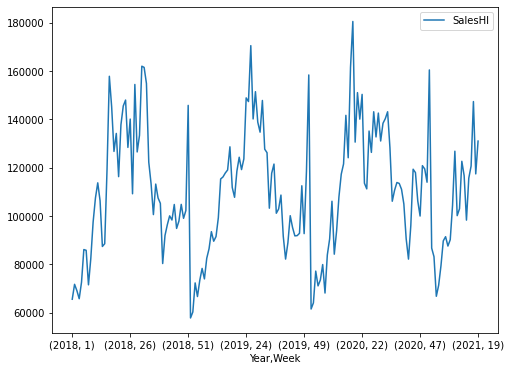

In [475]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'], figsize=(8,6))
plt.show()

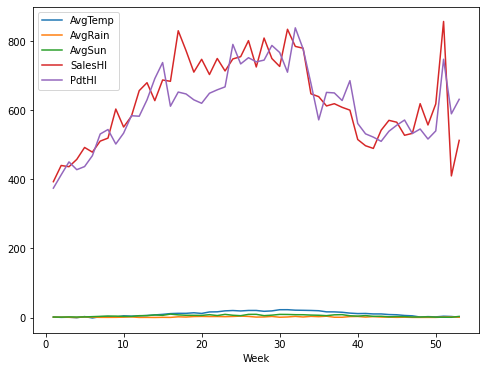

In [476]:
data.groupby(['Week']).mean().plot(y=['AvgTemp', 'AvgRain', 'AvgSun', 'SalesHl', 'PdtHl'], figsize=(8,6))
plt.show()

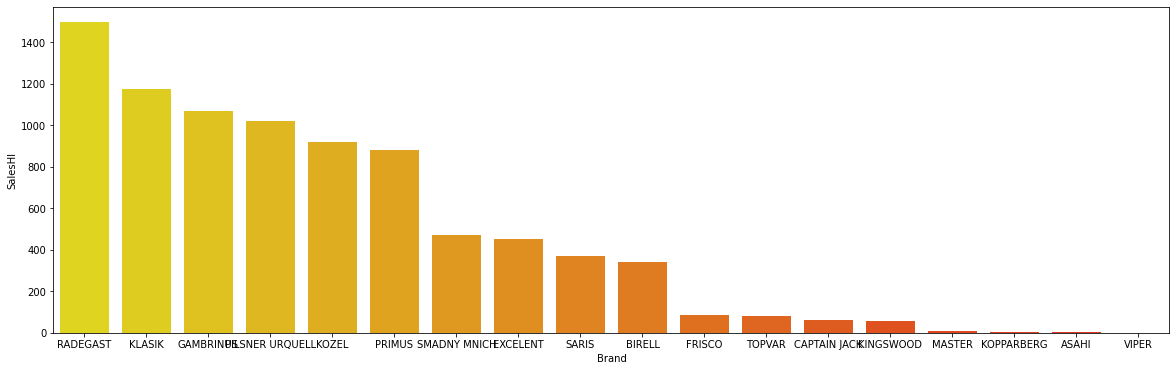

In [477]:
plt.figure(figsize=(20,6))
g_pps = data.groupby('Brand')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pps.index, y=g_pps, palette='autumn_r')
axis.set_xlabel('Brand')
axis.set_ylabel('SalesHl')

plt.show()

## Skewness and Kurtesis

In [478]:
data.skew()

SkuShort            0.556035
Year                0.193844
Week                0.130778
NumberWorkdays     -2.718426
AvgTemp             inf     
AvgRain             inf     
AvgSun              inf     
IsLockdown          1.273493
PdtHl               inf     
PrevWeekPdtHl1      inf     
BgtHl               inf     
SalesHl             5.312086
PrevWeekSalesHl1    inf     
PrevWeekSalesHl2    inf     
PrevYearSalesHl1    inf     
PrevYearSalesHl2    inf     
OldPredSalesHl      inf     
dtype: float64

In [479]:
data.kurt()

SkuShort           -0.753651 
Year               -1.048431 
Week               -1.215213 
NumberWorkdays      9.093542 
AvgTemp            NaN       
AvgRain            NaN       
AvgSun             NaN       
IsLockdown         -0.378240 
PdtHl              NaN       
PrevWeekPdtHl1     NaN       
BgtHl              NaN       
SalesHl             38.004614
PrevWeekSalesHl1   NaN       
PrevWeekSalesHl2   NaN       
PrevYearSalesHl1   NaN       
PrevYearSalesHl2   NaN       
OldPredSalesHl     NaN       
dtype: float64

## Spliting data in X and Y

In [480]:
cols_drop = ['SalesHl', 'OldPredSalesHl'] #'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year', 'BgtHl', 'Brand', 'SubBrand'

X = data.drop(cols_drop, axis=1)
X_raw = X.copy(deep=True)
y = data.SalesHl.to_numpy()
y_oldPred = data.OldPredSalesHl.fillna(0).to_numpy()

In [481]:
# X['NextWeek'] = X['Week']+1
# X = X.merge(workdays, how='left', left_on=['Country','Year','NextWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Next"))
# X = X.drop(['NextWeek',  'WeekNext'], axis=1) 
# X['NumberWorkdaysNext'] = X['NumberWorkdaysNext'].fillna(5)

# X['PrevWeek'] = X['Week']-1
# X = X.merge(workdays, how='left', left_on=['Country','Year','PrevWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Prev"))
# X = X.drop(['PrevWeek', 'WeekPrev', ], axis=1) #'NextWeek',  'WeekNext'
# X['NumberWorkdaysPrev'] = X['NumberWorkdaysPrev'].fillna(5)

X['NextWeek'] = X['Week']+1
X['PrevWeek'] = X['Week']-1

X = X.merge(workdays, how='left', left_on=['Country','Year','NextWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Next"))
X = X.merge(workdays, how='left', left_on=['Country','Year','PrevWeek'], right_on=['Country','Year','Week'], suffixes=(None, "Prev"))

X = X.drop(['PrevWeek', 'WeekPrev', 'NextWeek',  'WeekNext'], axis=1)
X['NumberWorkdaysPrev'] = X['NumberWorkdaysPrev'].fillna(5)
X['NumberWorkdaysNext'] = X['NumberWorkdaysNext'].fillna(5)
X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev
0,01015,PILSNER URQUELL,CZ,2018,1,4,5.113281,1.06250,0.924805,False,1510.000000,9968.00000,1606.000,5284.000000,14072.00,1001.50000,1805.000000,5.0,5.0
1,01015,PILSNER URQUELL,SK,2018,1,4,5.113281,1.06250,0.924805,False,537.000000,3196.00000,611.000,1250.000000,2776.00,195.75000,507.000000,5.0,5.0
2,01016,PILSNER URQUELL,CZ,2018,1,4,5.113281,1.06250,0.924805,False,197.625000,NaN,147.625,372.000000,559.00,130.12500,159.125000,5.0,5.0
3,01016,PILSNER URQUELL,SK,2018,1,4,5.113281,1.06250,0.924805,False,15.234375,33.28125,32.375,35.312500,123.25,20.43750,26.921875,5.0,5.0
4,01022,PILSNER URQUELL,CZ,2018,1,4,5.113281,1.06250,0.924805,False,NaN,283.25000,84.250,229.000000,314.00,99.31250,72.500000,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30882,16475,CAPTAIN JACK,SK,2021,19,5,14.109375,5.59375,5.882812,True,59.593750,21.59375,NaN,114.812500,109.00,NaN,NaN,5.0,5.0
30883,17551,VIPER,CZ,2021,19,5,14.109375,5.59375,5.882812,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
30884,17651,VIPER,CZ,2021,19,5,14.109375,5.59375,5.882812,True,NaN,NaN,NaN,0.079224,NaN,NaN,NaN,5.0,5.0
30885,18076,SMADNY MNICH,SK,2021,19,5,14.109375,5.59375,5.882812,True,77.937500,197.25000,164.875,126.625000,267.75,142.50000,71.875000,5.0,5.0


## LabelEncoder

In [482]:
Country_mapping = {"CZ": 1, "SK": 2}
# PrimaryPack_mapping = {"CAN": 1, "KEG": 2, "RB": 3, "NRB": 4, "TANK": 5, "PET": 6, "KEG ONE WAY": 7, "KEG WOODEN": 8}
# ProductGroup_mapping = {"CLEAR BEER": 1, "FLAVOURED BEER": 2, "CIDER": 3, "SOFT DRINKS": 4, "MALT BASED BEV": 5, "WHEAT BEER": 6, "FABS - Seltzer sugar base": 7, "CLEAR BEER - MIXED PALLET (CZSK)": 8}

X.Country = X.Country.map(Country_mapping)
# X.PrimaryPack = X.PrimaryPack.map(PrimaryPack_mapping)
# X.ProductGroup =  X.ProductGroup.map(ProductGroup_mapping)

le_sku = LabelEncoder()
X.SkuShort = le_sku.fit_transform(X.SkuShort)

le_brand = LabelEncoder()
X.Brand = le_brand.fit_transform(X.Brand)
# X.SubBrand = LabelEncoder().fit_transform(X.SubBrand)

X.head()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev
0,0,11,1,2018,1,4,5.113281,1.0625,0.924805,False,1510.000000,9968.00000,1606.000,5284.0000,14072.00,1001.5000,1805.000000,5.0,5.0
1,0,11,2,2018,1,4,5.113281,1.0625,0.924805,False,537.000000,3196.00000,611.000,1250.0000,2776.00,195.7500,507.000000,5.0,5.0
2,1,11,1,2018,1,4,5.113281,1.0625,0.924805,False,197.625000,NaN,147.625,372.0000,559.00,130.1250,159.125000,5.0,5.0
3,1,11,2,2018,1,4,5.113281,1.0625,0.924805,False,15.234375,33.28125,32.375,35.3125,123.25,20.4375,26.921875,5.0,5.0
4,2,11,1,2018,1,4,5.113281,1.0625,0.924805,False,NaN,283.25000,84.250,229.0000,314.00,99.3125,72.500000,5.0,5.0


## Imputer

In [483]:
X.BgtHl = X.BgtHl.fillna(0)
X.PdtHl = X.PdtHl.fillna(0)
X.PrevWeekPdtHl1 = X.PrevWeekPdtHl1.fillna(0)

In [484]:
si = SimpleImputer(strategy='mean')
# si = SimpleImputer(strategy='constant', fill_value=0)
# si = IterativeImputer(random_state=0, skip_complete=True, min_value=0)
# si = KNNImputer()

si.fit(X)
# X_train = si.transform(X_train)
# X_test = si.transform(X_test)
X = pd.DataFrame(si.transform(X), columns=X.columns)

## Adding a New Feature

In [485]:
#Avg 
X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)

X.head()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,0.0,11.0,1.0,2018.0,1.0,4.0,5.113281,1.0625,0.924805,0.0,1510.000000,9968.00000,1606.000,5284.0000,14072.00,1001.5000,1805.000000,5.0,5.0,9678.0,1403.2,5540.6
1,0.0,11.0,2.0,2018.0,1.0,4.0,5.113281,1.0625,0.924805,0.0,537.000000,3196.00000,611.000,1250.0000,2776.00,195.7500,507.000000,5.0,5.0,2013.0,351.4,1182.2
2,1.0,11.0,1.0,2018.0,1.0,4.0,5.113281,1.0625,0.924805,0.0,197.625000,0.00000,147.625,372.0000,559.00,130.1250,159.125000,5.0,5.0,465.5,144.6,305.1
3,1.0,11.0,2.0,2018.0,1.0,4.0,5.113281,1.0625,0.924805,0.0,15.234375,33.28125,32.375,35.3125,123.25,20.4375,26.921875,5.0,5.0,79.3,23.7,51.5
4,2.0,11.0,1.0,2018.0,1.0,4.0,5.113281,1.0625,0.924805,0.0,0.000000,283.25000,84.250,229.0000,314.00,99.3125,72.500000,5.0,5.0,271.5,85.9,178.7


In [486]:
X.tail()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,NumberWorkdaysNext,NumberWorkdaysPrev,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
30882,250.0,2.0,2.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,59.59375,21.59375,0.000,114.812500,109.000000,698.427959,740.339264,5.0,5.0,111.9,719.4,415.6
30883,251.0,17.0,1.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,0.00000,0.00000,0.000,640.981479,640.862543,698.427959,740.339264,5.0,5.0,640.9,719.4,680.2
30884,252.0,17.0,1.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,0.00000,0.00000,0.000,0.079224,640.862543,698.427959,740.339264,5.0,5.0,320.5,719.4,519.9
30885,254.0,15.0,2.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,77.93750,197.25000,164.875,126.625000,267.750000,142.500000,71.875000,5.0,5.0,197.2,107.2,152.2
30886,260.0,15.0,2.0,2021.0,19.0,5.0,14.109375,5.59375,5.882812,1.0,55.28125,138.12500,83.375,80.500000,197.500000,56.156250,47.875000,5.0,5.0,139.0,52.0,95.5


## Split train and test

In [487]:
train_index = len(X[(X.Year <= 2020) | ((X.Year == 2021) & (X.Week < 10))])
# train_index = len(X[(X.Year <= 2019) | ((X.Year == 2020) & (X.Week < 45))])

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 21)
 
X_train = X.iloc[:train_index]
y_train = y[:train_index]

X_test = X.iloc[train_index:]
X_test_raw = X_raw.iloc[train_index:]
y_test = y[train_index:]
y_test_oldPred = y_oldPred[train_index:]

## Scaler

In [488]:
# scaler = MinMaxScaler()
# scaler = MaxAbsScaler()
scaler = StandardScaler() 
# scaler = RobustScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

## Regressors

In [489]:
# model = ensemble.AdaBoostRegressor()
# model = tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True)
#model = ensemble.ExtraTreesRegressor(n_jobs=3)
# model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True)
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))])
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)

#model = linear_model.LogisticRegression(max_iter=10)
# model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)
# model = linear_model.Ridge(max_iter=1000, copy_X=True, fit_intercept=True, normalize=True, solver='sparse_cg')
# model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True)

# model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)
# model = linear_model.Lars(n_nonzero_coefs=1000) 
# model = linear_model.LassoLars(max_iter=500) 
# model = linear_model.OrthogonalMatchingPursuit()
# model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) 
# model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

# model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True) 
# model = linear_model.RANSACRegressor(max_trials=500)
# model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1)

#NOT model = linear_model.PoissonRegressor(max_iter=500)
# model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True) 
#NOT model = linear_model.GammaRegressor(max_iter=500) 
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) 

# model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) 
# model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR()

## Find best params

In [490]:
# param_grid = dict(learning_rate=[0.05], max_iter=[100], max_leaf_nodes=[140, 150, 160], min_samples_leaf=[25])
# clf = GridSearchCV(model, param_grid, n_jobs=2) #, random_state=0
# search = clf.fit(X_train, y_train.values.ravel())
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)

In [491]:
# # Train the model using the training sets
# model.fit(X_train, y_train.values.ravel())

# # Make predictions using the testing set
# y_pred = model.predict(X_test)
# y_pred[y_pred < 0] = 0
# y_pred = y_pred.round(0)

# # # The mean squared error
# # print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

# print(DATASET_NAME)
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# # #Best possible score is 1.0, lower values are worse.
# # print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

# #max_error metric calculates the maximum residual error.
# print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# # #Mean absolute percentage error regression loss.
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

# print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
# print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_test_oldPred))

## Models

### HistGradientBoostingRegressor 

In [492]:
hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=250, max_leaf_nodes=150, min_samples_leaf=25, early_stopping=False)

### MLPRegressor

In [493]:
mlpModel = neural_network.MLPRegressor(random_state=0, activation='relu', solver='adam', hidden_layer_sizes=100, shuffle=False, warm_start=True, max_iter=1000, early_stopping=False)

### RandomForestRegressor

In [494]:
rfModel = ensemble.RandomForestRegressor(random_state=0, criterion='mse', min_samples_split=2, min_samples_leaf=3, n_estimators=100, max_depth=None, max_features=None, bootstrap=True, oob_score=True, n_jobs=MAX_N_JOBS)

### XGBRegressor

In [495]:
xgbModel = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_jobs=MAX_N_JOBS)

### CatBoostRegressor

In [496]:
cbModel = catboost.CatBoostRegressor(learning_rate=0.05, eval_metric='RMSE', loss_function='RMSE', bootstrap_type='No', leaf_estimation_method='Newton', random_seed=42, verbose=0)

### LGBMRegressor

In [497]:
lgbmModel = lightgbm.LGBMRegressor(random_state=0, boosting_type='goss', learning_rate=0.2, num_leaves=35, n_estimators=50, n_jobs=MAX_N_JOBS)

### ExtraTreesRegressor

In [498]:
etrModel = ensemble.ExtraTreesRegressor(bootstrap=True, criterion='mse', max_features='auto', oob_score=True, warm_start=True, n_estimators=200, min_weight_fraction_leaf=0, min_samples_split=2 , min_samples_leaf=2, ccp_alpha=0.7)

### Use models

In [499]:
regression_models = [lgbmModel, cbModel, hgbModel, rfModel, etrModel] #xgbModel
regression_models

[LGBMRegressor(boosting_type='goss', learning_rate=0.2, n_estimators=50,
               n_jobs=8, num_leaves=35, random_state=0),
 HistGradientBoostingRegressor(early_stopping=False, learning_rate=0.05,
                               max_iter=250, max_leaf_nodes=150,
                               min_samples_leaf=25, random_state=0),
 RandomForestRegressor(max_features=None, min_samples_leaf=3, n_jobs=8,
                       oob_score=True, random_state=0),
 ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.7, min_samples_leaf=2,
                     min_weight_fraction_leaf=0, n_estimators=200,
                     oob_score=True, warm_start=True)]

In [500]:
%%time

estimators = []
result_models = pd.DataFrame(columns=['Model', 'Score', "AbsoluteScore", 'ME', 'MSE', 'MAE'])

for reg_model in regression_models:
    
    reg_model.fit(X_train, y_train)
    y_pred = reg_model.predict(X_test)
    
    model_name = type(reg_model).__name__
    score = r2_score(y_test, y_pred)
    abs_score = absolute_score(y_test, y_pred)
    me = max_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    result_models.loc[len(result_models.index)] = [model_name, score, abs_score, me, mse, mae]

    estimators.append((model_name, reg_model))

Wall time: 1min 2s


In [501]:
col_metric = 'AbsoluteScore'
max_score = result_models[col_metric].max()
min_score = result_models[col_metric].min()
min_weight = min_score - ((max_score - min_score) * 0.2)

result_models["Weights"] = result_models[col_metric].map(lambda x: round((x - min_weight) / (max_score - min_weight), 2))
result_models.sort_values(by=[col_metric], ascending=False)

,Model,Score,AbsoluteScore,ME,MSE,MAE,Weights
3,RandomForestRegressor,0.867346,0.644054,4683.655032,332727.695915,242.465486,1.00
2,HistGradientBoostingRegressor,0.867388,0.635100,4968.191436,332622.854022,248.565087,0.75
0,LGBMRegressor,0.874713,0.634082,4799.986938,314249.791787,249.258359,0.72
4,ExtraTreesRegressor,0.858600,0.625729,5018.689932,354664.938949,254.948718,0.49
1,CatBoostRegressor,0.853398,0.614149,5764.361347,367713.674888,262.836689,0.17


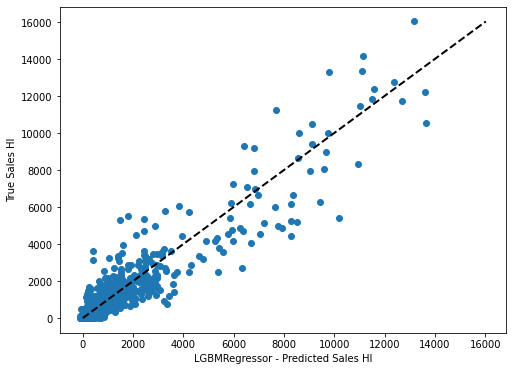

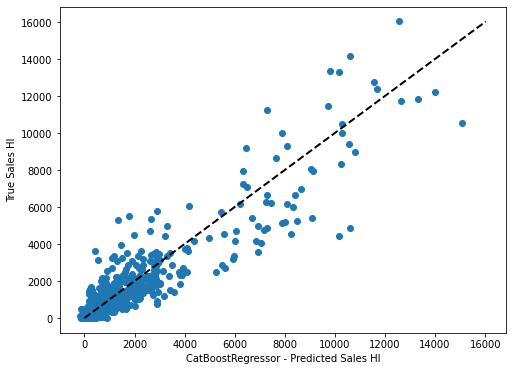

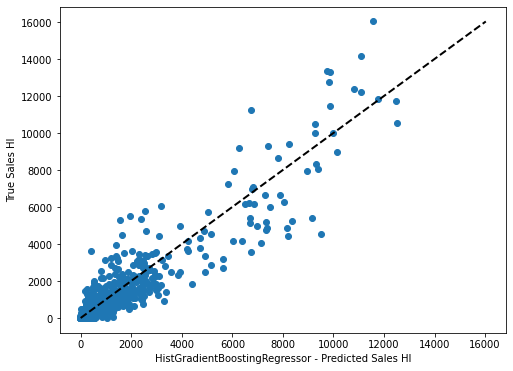

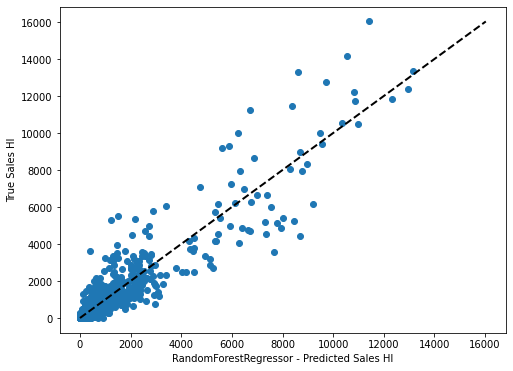

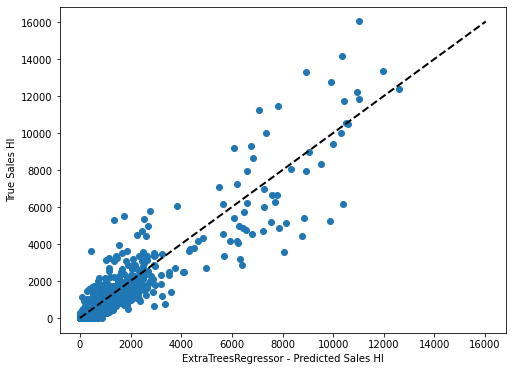

In [502]:
for key, model in estimators:
    y_pred = model.predict(X_test)
    show_pred(y_test, y_pred, f"{key} - Predicted Sales Hl", "True Sales Hl")

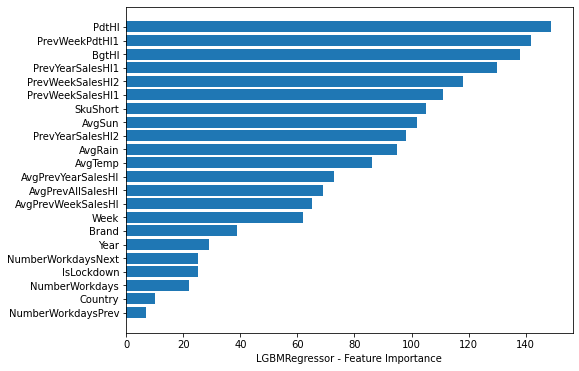

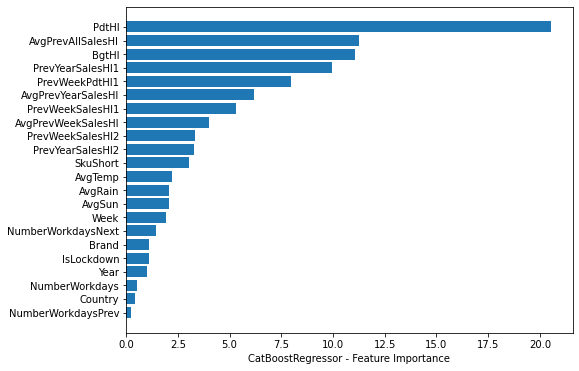

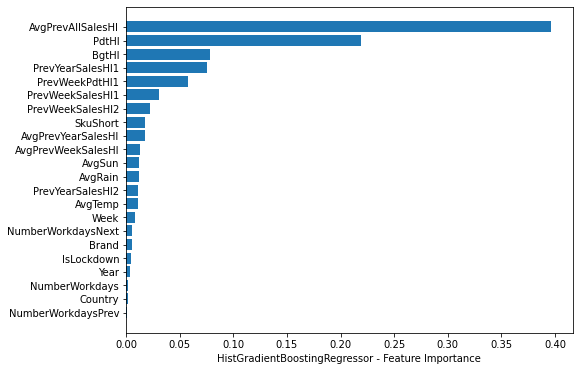

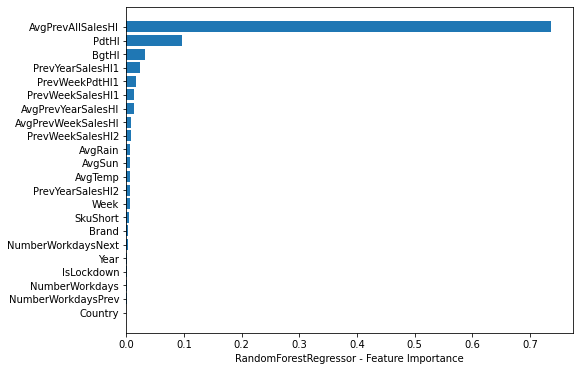

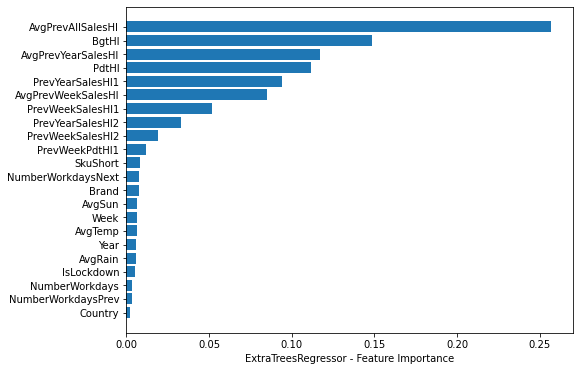

In [503]:
for key, model in estimators:
    show_feature_importances(model, X_test, y_test)

### VotingRegressor

In [504]:
%%time

model = ensemble.VotingRegressor(estimators=estimators, weights=result_models.Weights.values, n_jobs=1)

model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

Wall time: 1min 5s


In [505]:
print(DATASET_NAME)
print('----------------')
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))
print('Absolute Score: %.4f'% absolute_score(y_test, y_pred))
print('Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_pred))
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))
print('Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_pred))

print('----------------')

print('Classic Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
print('Classic Absolute Score: %.4f'% absolute_score(y_test, y_test_oldPred))
print('Classic Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_test_oldPred))
print('Classic Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
print('Classic Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_test_oldPred))


off-trade
----------------
Coefficient of determination: 0.8766
Absolute Score: 0.6459
Mean absolute error regression loss.: 241.2085
Maximum residual error: 4178.2000
Mean squared error regression loss: 309396.4537
----------------
Classic Coefficient of determination: 0.9544
Classic Absolute Score: 0.7964
Classic Mean absolute error regression loss.: 138.6972
Classic Maximum residual error: 4026.0000
Classic Mean squared error regression loss: 114415.4584


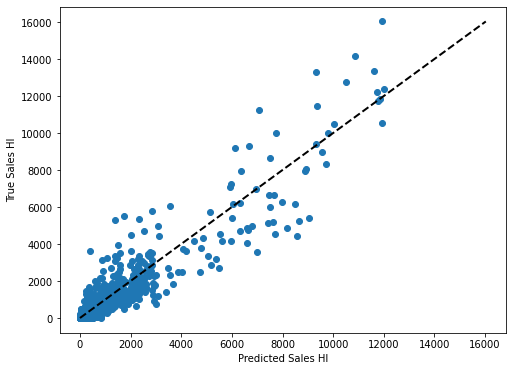

In [506]:
show_pred(y_test, y_pred, "Predicted Sales Hl", "True Sales Hl")

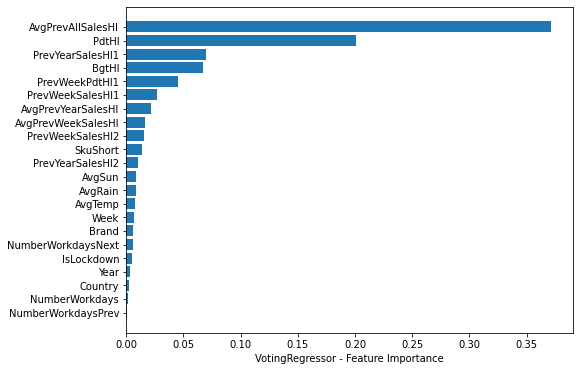

Wall time: 2min 17s


In [507]:
%%time

show_feature_importances(model, X_test, y_test)

## Save Result

In [512]:
result = X_test_raw.copy(deep=True)
result["TrueSalesHl"] = y_test
result["PredSalesHl_Classic"] = y_test_oldPred
result["PredSalesHl_ML"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [509]:
dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH, compress=True)

['./models/off-trade_model.joblib']

## Use model

In [510]:

# file = open(MODEL_PATH, 'rb')

# model = joblib.load(file)

# SkuShort = 2605
# Week = 23
# NumberWorkdays = 5
# AvgTemp = 15.892857142857142
# AvgRain = 3.5000000000000004
# AvgSun = 6.735714285714286
# IsLockdown = 0
# PdtHl = -1.0
# PrevWeekPdtHl1 = -1.0
# BgtHl = 6665
# PrevWeekBgtHl1 = 6665.949490847161
# PrevWeekSalesHl1 = 5020
# PrevWeekSalesHl2 = 5038
# SalesHl = 5386.5

# x = np.array([[SkuShort, Week,NumberWorkdays, AvgTemp, AvgRain, AvgSun, IsLockdown, PdtHl, PrevWeekPdtHl1, BgtHl, PrevWeekBgtHl1, PrevWeekSalesHl1, PrevWeekSalesHl2]])

# y_pred = model.predict(x)
# result = y_pred[0]

# def get_percentage_diff(previous, current):
#     return 1 - (abs(previous - current)/max(previous, current))

# print('Forecast sales: %.4f hl'% result)
# print('Coefficient of determination: %.4f'% get_percentage_diff(SalesHl, result))

#full with sku = 0.7678
#full = 0.7363